In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
num_segments = 100
num_targets_per_segment = 100

num_targets = repeat(num_targets_per_segment, num_segments)

# segment-level means are drawn from Uniform(-5, 5)
means = random.uniform(-5, 5, num_segments)

# target-level log_2 coverages are drawn from 0.95 * Norm(mean, sqrt(var)) + 0.05 * Uniform(-10, 10)
variance = 1.
outlier_prob = 0.05
target = 0
coverages = []
outlier_indicators = []
for s in range(num_segments):
    for t in range(num_targets[s]):
        if random.random() < outlier_prob:
            coverages.append(random.uniform(-10, 10))
            outlier_indicators.append(1)
        else:
            coverages.append(random.normal(means[s], sqrt(variance)))
            outlier_indicators.append(0)
        target += 1
coverages = array(coverages)

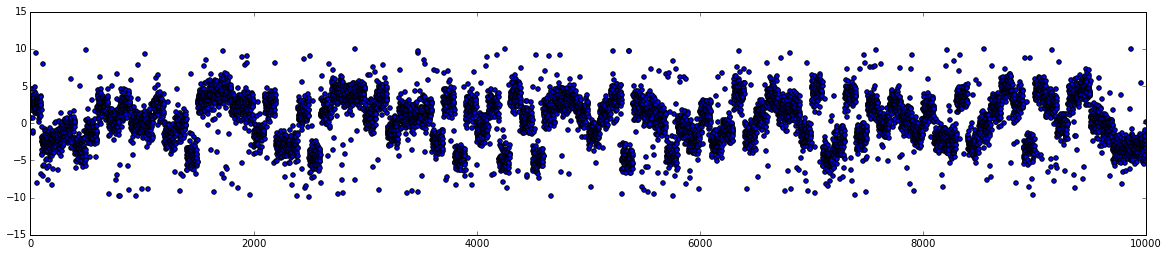

In [3]:
fig = plt.figure(figsize=(20, 4))
scatter(range(len(coverages)), coverages)
xlim([0, len(coverages)])
show()

In [4]:
test_dir = '../src/test/resources/org/broadinstitute/hellbender/tools/exome/'

In [5]:
# convert num_targets into a segment file; all targets span 10 positions, chromosomes each have 10 segments
# convert coverages into a target-coverage file; all targets span 10 positions
sample = 'test'
name_prefix = 't'
chromosome_names = [str(i) for i in range(1, 11)]

segment_pd = pd.DataFrame(columns=['Sample', 'Chromosome', 'Start', 'End'])
coverages_pd = pd.DataFrame(columns=['name', 'contig', 'start', 'stop', sample])

target_index = 0
segments_per_chromosome = 10
for i, chromosome in enumerate(chromosome_names):
    end = 0
    for segment_index in range(segments_per_chromosome * i, segments_per_chromosome * (i + 1)):
        start = end + 1
        end = end + 10 * num_targets[segment_index]
        segment_pd.loc[segment_index] = [sample, chromosome, start, end]
        for target_start in range(start, end, 10):
            name = name_prefix + str(target_index + 1)
            coverages_pd.loc[target_index] = [name, 
                                              chromosome, target_start, target_start + 9, 
                                              around(coverages[target_index], decimals=2)]
            target_index += 1
        
segment_pd['Start'] = segment_pd['Start'].astype(int)
segment_pd['End'] = segment_pd['End'].astype(int)
coverages_pd['start'] = coverages_pd['start'].astype(int)
coverages_pd['stop'] = coverages_pd['stop'].astype(int)

segment_pd.to_csv(test_dir + 'segments-for-copy-ratio-modeller.seg', sep='\t', index=False)
coverages_pd.to_csv(test_dir + 'coverages-for-copy-ratio-modeller.tsv', sep='\t', index=False)
savetxt(test_dir + 'segment-means-truth-for-copy-ratio-modeller.txt', means, fmt='%.3f')
savetxt(test_dir + 'outlier-indicators-truth-for-copy-ratio-modeller.txt', outlier_indicators, fmt='%d')